<a href="https://colab.research.google.com/github/poku0857643/LSTM-predict-T1DM-CGM-using-BGrisk/blob/main/LSTM_model_T1DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CGMBGrisk0924.csv")

In [ ]:
def split_data(data, train_ratio=0.7, test_ratio=0.2):
    """
    Splits the data into training, testing, and validation sets.
    """
    n = len(data)
    train_end = int(train_ratio * n)
    test_end = int((train_ratio + test_ratio) * n)
    train_data = data[:train_end]
    test_data = data[train_end:test_end]
    val_data = data[test_end:]
    return train_data, test_data, val_data

n_steps_in = 5

def create_sequences(data, n_steps_in, n_steps_out=1):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in, :-1]) # all columns but the last are features
        #y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out, -1]) # the last column is the target
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out, -1].reshape(-1))

    return np.array(X), np.array(y)

# Splitting and creating sequences for each patient
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []
X_val_all, y_val_all = [], []

unique_patients = data['PtID'].unique()

for pid in unique_patients:
    patient_data = data[data['PtID'] == pid][['Normalized BGrisk', 'Value']].values

    # Split the data
    train_patient_data, test_patient_data, val_patient_data = split_data(patient_data)

    # Normalize the training data and transform the test and validation data using the same parameters
    scaler = MinMaxScaler()
    train_patient_data_normalized = scaler.fit_transform(train_patient_data)
    test_patient_data_normalized = scaler.transform(test_patient_data)
    val_patient_data_normalized = scaler.transform(val_patient_data)

    # Create sequences
    X_train, y_train = create_sequences(train_patient_data_normalized, n_steps_in)
    X_test, y_test = create_sequences(test_patient_data_normalized, n_steps_in)
    X_val, y_val = create_sequences(val_patient_data_normalized, n_steps_in)

    X_train_all.append(X_train)
    y_train_all.append(y_train)
    X_test_all.append(X_test)
    y_test_all.append(y_test)
    X_val_all.append(X_val)
    y_val_all.append(y_val)

# Convert lists to numpy arrays
X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
X_test_all = np.concatenate(X_test_all, axis=0)
y_test_all = np.concatenate(y_test_all, axis=0)
X_val_all = np.concatenate(X_val_all, axis=0)
y_val_all = np.concatenate(y_val_all, axis=0)

X_train_all.shape, y_train_all.shape, X_test_all.shape, y_test_all.shape, X_val_all.shape, y_val_all.shape


((1616026, 5, 1),
 (1616026, 1),
 (460520, 5, 1),
 (460520, 1),
 (229622, 5, 1),
 (229622, 1))

In [ ]:
import time
from keras.callbacks import Callback

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        print(f"Epoch {epoch + 1} time: {self.times[-1]:.2f} seconds")

time_callback = TimeHistory()

In [ ]:
import tensorflow as tf
from keras.layers import Dropout, Dense
# Define the model
model = Sequential()
n_features = X_train_all.shape[2]  # Number of features in the data
model.add(LSTM(50, activation='tanh', stateful=False, return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(n_features))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['Acc'])

# You don't need to reshape the data again if X_train_all and X_test_all already have the shape [samples, time steps, features]
# If not, you can reshape it like this:
# X_train_01 = X_train_all.reshape((X_train_all.shape[0], X_train_all.shape[1], n_features))
# X_test_01 = X_test_all.reshape((X_test_all.shape[0], X_test_all.shape[1], n_features))

# Fit model
history = model.fit(X_train_all, y_train_all, epochs=3, verbose=0, callbacks=[time_callback])

# Make predictions
predictions = model.predict(X_test_all)


Epoch 1 time: 427.65 seconds
Epoch 2 time: 388.67 seconds
Epoch 3 time: 427.17 seconds
14392/14392 [==============================] - 44s 3ms/step


In [ ]:
print("Before squeeze:", predictions.shape)
predictions = np.squeeze(predictions)
print("After squeeze:", predictions.shape)
print("X_test_all shape:", X_test_all.shape)


Before squeeze: (460520, 1)
After squeeze: (460520,)
X_test_all shape: (460520, 5, 1)


In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def evaluate_model(y_true, predictions):
    """
    Computes and returns the RMSE between true and predicted values.
    """
    rmse_value = np.sqrt(mean_squared_error(y_true, predictions))
    return rmse_value

def visualize_performance(history):
    """
    Visualizes the RMSE learning and loss performance during training.
    """
    # Plotting loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plotting RMSE - Note: You need to have RMSE as a metric in your model training to plot this
    # If it's not there, this part can be commented out or removed
    if 'Acc' in history.history:  # Assuming 'Acc' is the metric for RMSE
        plt.subplot(1, 2, 2)
        plt.plot(history.history['Acc'], label='Training RMSE')
        if 'val_Acc' in history.history:
            plt.plot(history.history['val_Acc'], label='Validation RMSE')
        plt.title('Model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Since I don't have the history object from your model training, I can't directly visualize it here.
# However, you can use it in your actual implementation like:
# visualize_performance(history_from_training)


In [ ]:
evaluate_model(y_test_all, predictions)

0.027050965012574785

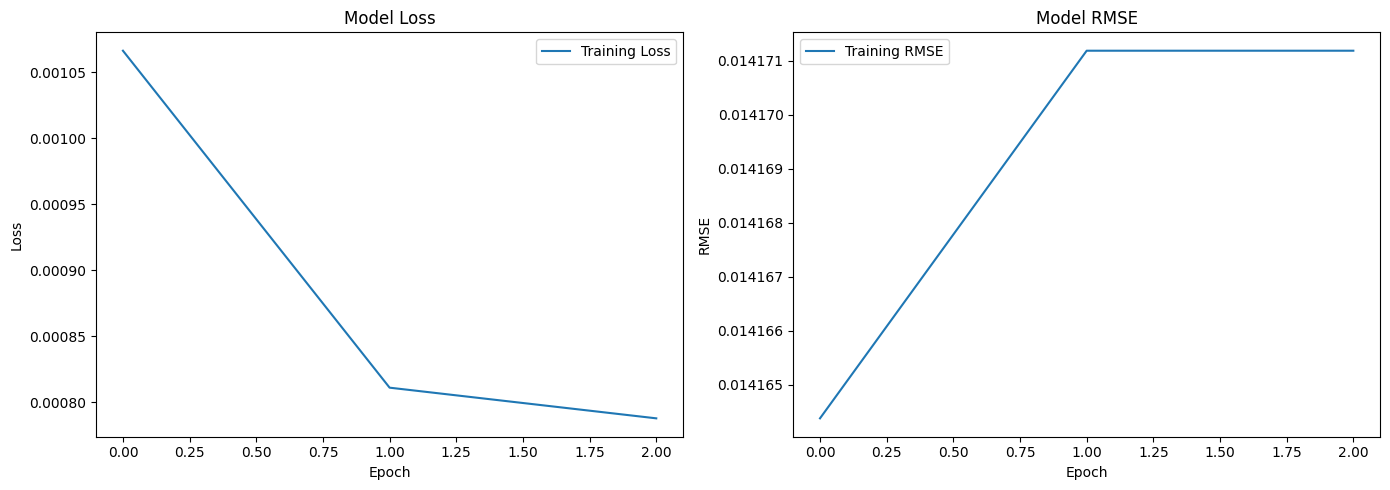

In [ ]:
visualize_performance(history)

In [ ]:
import json
def save_training_history(history, filename='training_history.json'):
    """
    Save the training history to a JSON file.
    """
    with open(filename, 'w') as f:
        json.dump(history.history, f)

def load_training_history(filename='training_history.json'):
    """
    Load the training history from a JSON file.
    """
    with open(filename, 'r') as f:
        loaded_history = json.load(f)
    return loaded_history

def train_with_tensorboard(model, X_train, y_train, X_val, y_val, epochs=10, log_dir='./logs'):
    """
    Train the model and log the training details for visualization with TensorBoard.
    """
    tensorboard = TensorBoard(log_dir=log_dir)
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard])
    return history

# Since I don't have the data, model, and actual setup, I can't run the functions.
# However, you can use the functions in your actual implementation as described.


In [ ]:
save_training_history(history, filename='/content/drive/MyDrive/T1DMLSTMCGM.json')